# Pressure Level 2km

In [1]:
import xarray as xr
import numpy as np
import dask as dask
from matplotlib import pyplot as plt
%matplotlib inline
import intake
import pandas as pd
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
import gsw

In [2]:
ds_sose = xr.open_zarr('/swot/SUM03/tmp/SOSE')
ds_sose

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [8]:
ds_sose.THETA.Z.values

array([-5.0000e+00, -1.5500e+01, -2.7000e+01, -3.9500e+01, -5.3000e+01,
       -6.8000e+01, -8.5000e+01, -1.0400e+02, -1.2550e+02, -1.5000e+02,
       -1.7750e+02, -2.0850e+02, -2.4350e+02, -2.8300e+02, -3.2800e+02,
       -3.7950e+02, -4.3850e+02, -5.0600e+02, -5.8300e+02, -6.7100e+02,
       -7.7200e+02, -8.8800e+02, -1.0210e+03, -1.1735e+03, -1.3485e+03,
       -1.5495e+03, -1.7805e+03, -2.0460e+03, -2.3190e+03, -2.5750e+03,
       -2.8250e+03, -3.0750e+03, -3.3250e+03, -3.5750e+03, -3.8250e+03,
       -4.0750e+03, -4.3250e+03, -4.5750e+03, -4.8250e+03, -5.0750e+03,
       -5.3250e+03, -5.5750e+03], dtype=float32)

In [13]:
sst_2 = ds_sose.THETA.sel(Z=-2e3, method='nearest')
sss_2 = ds_sose.SALT.sel(Z=-2e3, method='nearest')

In [14]:
#lazy mode
#converting practical salinity to absolute salinity
sa_2 = xr.apply_ufunc(gsw.SA_from_SP, sss_2, 2000, ds_sose.XC, ds_sose.YC,
                    output_dtypes=[sss_2.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_2

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [17]:
#converting potential temperature to conservative temperature
ct_2 = xr.apply_ufunc(gsw.CT_from_pt, sa_2, sst_2,
                    output_dtypes=[sss_2.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_2

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

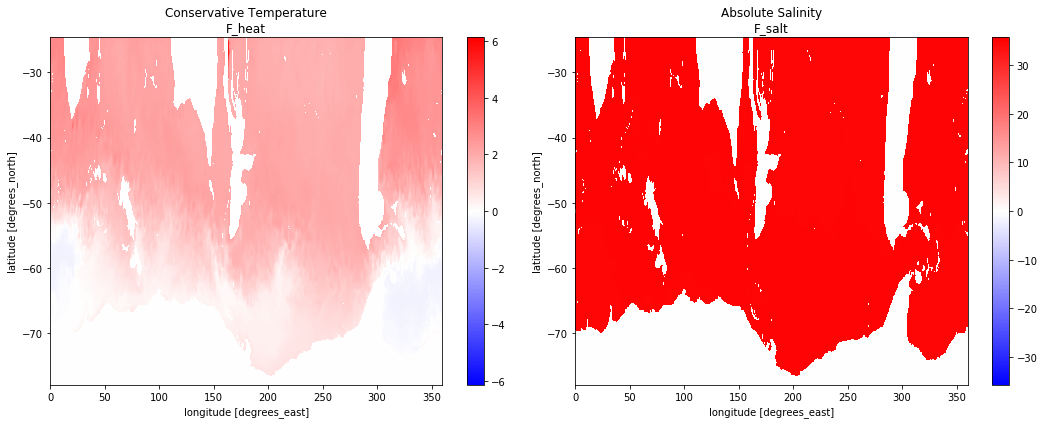

In [18]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ct_2[0].plot(ax=ax0, cmap='bwr')
ax0.set_title('Conservative Temperature\nF_heat')
sa_2[0].plot(ax=ax1, cmap='bwr')
ax1.set_title('Absolute Salinity\nF_salt')
plt.tight_layout();

## Compute Density Flux

In [20]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

### alpha at P=2km

In [19]:
alpha_2 = xr.apply_ufunc(gsw.alpha, sa_2, ct_2, 2000,
                    output_dtypes=[sst_2.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_2

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [21]:
a2 = alpha_2[0].load()

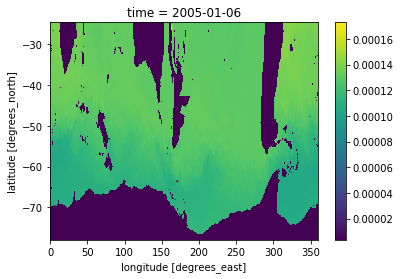

In [22]:
a2.plot()

### beta at P=2km

In [23]:
beta_2 = xr.apply_ufunc(gsw.beta, sa_2, ct_2, 2000,
                      output_dtypes=[sss_2.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_2

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [24]:
b2 = beta_2[0].load()

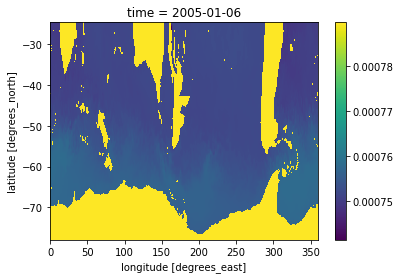

In [25]:
b2.plot()

## Temperature component of F_sigma at 2km

In [26]:
F_sig_heat_2 = (alpha_2 * ds_sose.TFLUX) / heat_capacity_cp
F_sig_heat_2 #kg/m^2/s

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Text(0.5, 1.0, 'temperature component of\ndensity flux\nat t=0')

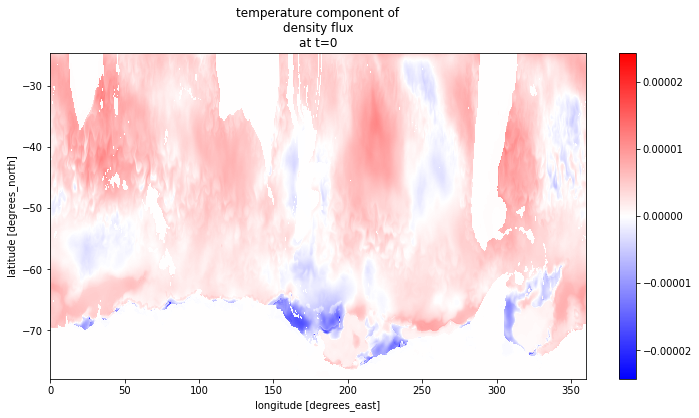

In [27]:
F_sig_heat_2[0].plot(figsize=(12,6), cmap='bwr')
plt.title('temperature component of\ndensity flux\nat t=0')

In [28]:
#temperature annual mean
group_time_heat_2 = F_sig_heat_2.groupby('time.month').mean(dim='time')
ann_mean_heat_2 = group_time_heat_2.mean(dim='month')
ann_mean_heat_2.load()

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.080996e-06, 1.079521e-06, 1.077429e-06, ..., 1.065097e-06,
        1.071513e-06, 1.078357e-06],
       [1.130810e-06, 1.130238e-06, 1.129420e-06, ..., 1.110568e-06,
        1.117772e-06, 1.126458e-06],
       [1.161789e-06, 1.161827e-06, 1.161319e-06, ..., 1.140063e-06,
        1.146946e-06, 1.156409e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

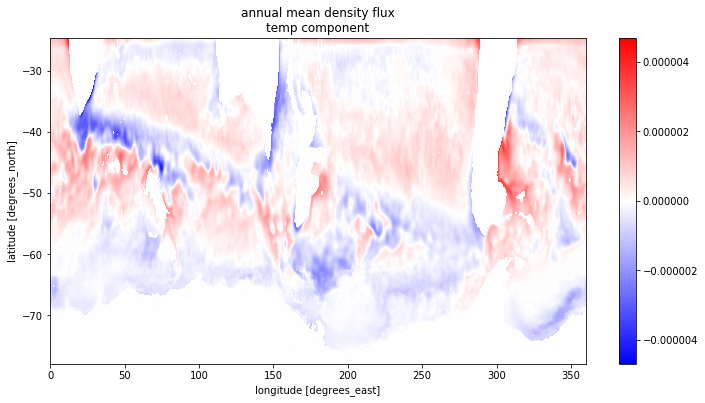

In [29]:
ann_mean_heat_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\ntemp component');

In [30]:
#OFF BY A FACTOR OF 10e-1
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_heat_2 = (ann_mean_heat_2*(-9.81)*10e6) / (10*runit2mass)
buoyancy_flux_heat_2

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.010246, -0.010232, -0.010212, ..., -0.010095, -0.010156, -0.010221],
       [-0.010718, -0.010713, -0.010705, ..., -0.010526, -0.010595, -0.010677],
       [-0.011012, -0.011012, -0.011007, ..., -0.010806, -0.010871, -0.010961]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

Text(0.5, 1.0, 'annual mean buoyancy flux\ntemp component')

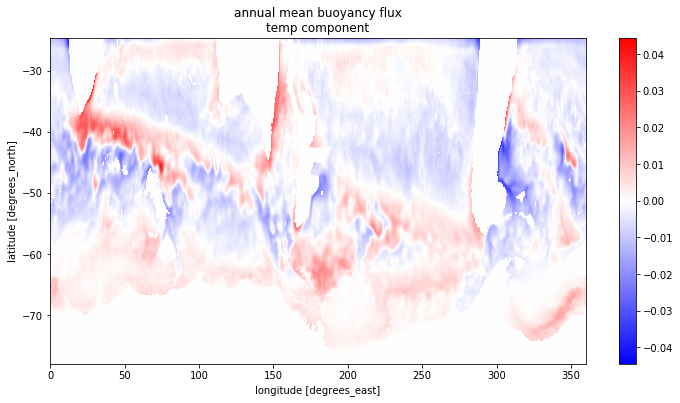

In [31]:
buoyancy_flux_heat_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\ntemp component')

### Salinity component of F_sigma

$$
F_{\sigma_{salt}} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta*SFLUX
$$

In [32]:
F_sig_salt_2 = beta_2 * ds_sose.SFLUX
F_sig_salt_2

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

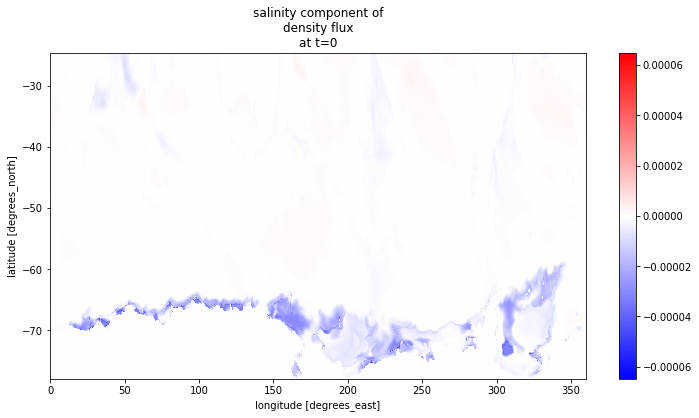

In [33]:
F_sig_salt_2[0].plot(figsize=(12,6), cmap='bwr')
plt.title('salinity component of\ndensity flux\nat t=0');

In [34]:
#temperature annual mean
group_time_salt_2 = F_sig_salt_2.groupby('time.month').mean(dim='time')
ann_mean_salt_2 = group_time_salt_2.mean(dim='month')
ann_mean_salt_2.load()

<xarray.DataArray (YC: 320, XC: 2160)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.060496e-06, 1.062198e-06, 1.063498e-06, ..., 1.053454e-06,
        1.055326e-06, 1.057817e-06],
       [1.057935e-06, 1.059279e-06, 1.060366e-06, ..., 1.052225e-06,
        1.053798e-06, 1.055816e-06],
       [1.059399e-06, 1.060608e-06, 1.061769e-06, ..., 1.054489e-06,
        1.055955e-06, 1.057640e-06]], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 

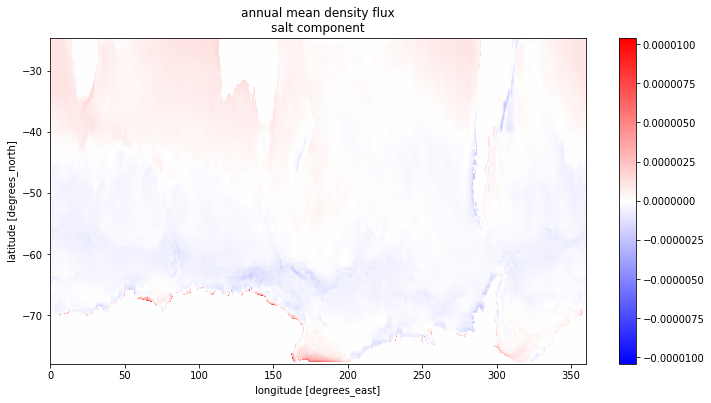

In [35]:
ann_mean_salt_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean density flux\nsalt component');

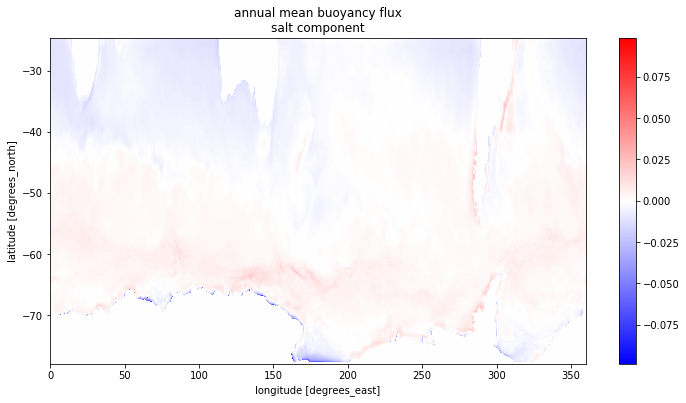

In [36]:
#density flux to buoyancy flux -> multiply by (-g/rho_0)
#to get ferrari's mm^2 units *10e6
buoyancy_flux_salt_2 = ann_mean_salt_2*(-9.81)*10e6/ (10*runit2mass)
buoyancy_flux_salt_2.plot(figsize=(12,6), cmap='bwr')
plt.title('annual mean buoyancy flux\nsalt component');

## Total Buoyancy Flux at different reference pressure levels $$with\ units\ of\ \frac{mm^{2}}{s^{3}} $$

In [38]:
buoyancy_flux_total_2 = buoyancy_flux_heat_2 + buoyancy_flux_salt_2
buoyancy_flux_total_2

<xarray.DataArray (YC: 320, XC: 2160)>
array([[-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      , ..., -0.      , -0.      , -0.      ],
       ...,
       [-0.020298, -0.0203  , -0.020292, ..., -0.02008 , -0.020159, -0.020247],
       [-0.020745, -0.020753, -0.020755, ..., -0.0205  , -0.020583, -0.020684],
       [-0.021053, -0.021065, -0.021071, ..., -0.020801, -0.02088 , -0.020985]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 5147.7617 5095.1714 5095.1714
    rA       (YC, XC) float32 72118200.0 72118200.0 ... 311911140.0 311911140.0

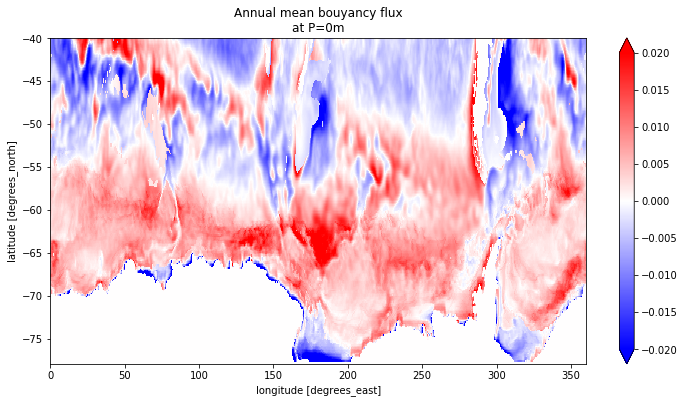

In [39]:
#perhaps it looks different from Ferrari because mine is over 5 years of sose and his is over 3
#but he doesn't specify the yrs he did the avg over
buoyancy_flux_total_2.sel(YC=slice(-80,-40)).plot(figsize=(12,6), cmap='bwr', vmin=-0.02, vmax=0.02)
plt.title('Annual mean bouyancy flux\nat P=0m');